# CAUTION THIS MODEL HAS BEEN RUN ON GOOGLE COLAB!! ONE CAN DIRECTLY USE THE TRAINED WEIGHTS BY LOADING THE MODEL AND USE THEM FOR PREDICTION OR WISH TO TRAIN HIS/HER OWN MODEL

In [3]:
!pip install tensorflow-gpu

     |████████████████████████████████| 454.3MB 36kB/s 
     |████████████████████████████████| 471kB 39.4MB/s 
     |████████████████████████████████| 4.0MB 25.7MB/s 
     |████████████████████████████████| 6.0MB 20.4MB/s 
     |████████████████████████████████| 1.2MB 46.1MB/s 
     |████████████████████████████████| 4.0MB 38.7MB/s 
     |████████████████████████████████| 4.9MB 23.6MB/s 
ERROR: tensorflow 2.4.1 has requirement gast==0.3.3, but you'll have gast 0.4.0 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement grpcio~=1.32.0, but you'll have grpcio 1.34.1 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement h5py~=2.10.0, but you'll have h5py 3.1.0 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement tensorflow-estimator<2.5.0,>=2.4.0, but you'll have tensorflow-estimator 2.5.0 which is incompatible.
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estim

In [1]:
!nvidia-smi

Sat May 15 06:23:26 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import tensorflow as tf
tf.__version__

'2.4.1'

In [3]:
!pip install split-folders

In [4]:
!unzip "/content/drive/MyDrive/Datasets/brain_hemmorhage.zip"

Archive:  /content/drive/MyDrive/Datasets/brain_hemmorhage.zip
  inflating: head_ct/head_ct/000.png  
  inflating: head_ct/head_ct/001.png  
  inflating: head_ct/head_ct/002.png  
  inflating: head_ct/head_ct/003.png  
  inflating: head_ct/head_ct/004.png  
  inflating: head_ct/head_ct/005.png  
  inflating: head_ct/head_ct/006.png  
  inflating: head_ct/head_ct/007.png  
  inflating: head_ct/head_ct/008.png  
  inflating: head_ct/head_ct/009.png  
  inflating: head_ct/head_ct/010.png  
  inflating: head_ct/head_ct/011.png  
  inflating: head_ct/head_ct/012.png  
  inflating: head_ct/head_ct/013.png  
  inflating: head_ct/head_ct/014.png  
  inflating: head_ct/head_ct/015.png  
  inflating: head_ct/head_ct/016.png  
  inflating: head_ct/head_ct/017.png  
  inflating: head_ct/head_ct/018.png  
  inflating: head_ct/head_ct/019.png  
  inflating: head_ct/head_ct/020.png  
  inflating: head_ct/head_ct/021.png  
  inflating: head_ct/head_ct/022.png  
  inflating: head_ct/head_ct/023.png  
 

# DATA PREPROCESSING

In [6]:
import pandas as pd
labels=pd.read_csv("/content/labels.csv")

In [7]:
labels[' hemorrhage']=labels[' hemorrhage'].astype("string")
labels["id"]=labels["id"].astype("string")

In [8]:
indices=labels.iloc[0:10]["id"].index
for i in indices.tolist():
    labels['id'][i]="00"+str(i)

In [9]:
indices=labels.iloc[10:100]["id"].index
for i in indices.tolist():
    labels['id'][i]="0"+labels['id'][i]

In [10]:
labels = labels.sort_values(' hemorrhage')
class_names = list(labels[' hemorrhage'].unique())

In [12]:
#creating subfolders
import os
for i in class_names:
    os.makedirs(os.path.join('data_',i))

In [14]:
#moving the image files to their respective categories
import shutil
for c in class_names: # Category Name
    for i in list(labels[labels[' hemorrhage']==c]['id']): # Image Id
        get_image = os.path.join('/content/head_ct/head_ct/', i+".png") # Path to Images
        move_image_to_cat = shutil.copy(get_image, '/content/data_/'+c)

In [15]:
!pip install split-folders

In [16]:
import splitfolders

In [17]:
splitfolders.ratio('/content/data_', output='output', seed=1337, ratio=(.6, 0.3,0.1))

Copying files: 200 files [00:00, 3927.51 files/s]


In [5]:
# import the libraries as shown below

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [19]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]  #VGG 19 input size

train_path = '/content/output/train'
valid_path = '/content/output/val'

In [59]:
original_model = VGG19(weights='imagenet')

574717952/574710816 [==============================] - 3s 0us/step


In [61]:
vgg = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

80142336/80134624 [==============================] - 1s 0us/step


In [62]:
# don't train existing weights 
for layer in vgg.layers:
    layer.trainable = False

In [23]:
folders = glob('/content/output/train/*')

In [63]:
x = Flatten()(vgg.output)

In [65]:
prediction = Dense(len(folders), activation='softmax')(x)
#len(folders) is 2 since we have 2 classes

# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

In [66]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [67]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [32]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('/content/output/train',
                                                 target_size = (224, 224),
                                                 batch_size = 16,
                                                 class_mode = 'categorical')

Found 120 images belonging to 2 classes.


In [33]:
test_set = test_datagen.flow_from_directory('/content/output/val',
                                            target_size = (224, 224),
                                            batch_size = 16,
                                            class_mode = 'categorical')

Found 60 images belonging to 2 classes.


## CHange the model / Increase dataset

In [75]:
# fit the model
# Run the cell. It will take some time to execute
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=17,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/17
8/8 [==============================] - 2s 306ms/step - loss: 0.0189 - accuracy: 1.0000 - val_loss: 0.2438 - val_accuracy: 0.9000
Epoch 2/17
8/8 [==============================] - 2s 286ms/step - loss: 0.0235 - accuracy: 1.0000 - val_loss: 0.2366 - val_accuracy: 0.8667
Epoch 3/17
8/8 [==============================] - 2s 311ms/step - loss: 0.0150 - accuracy: 1.0000 - val_loss: 0.2398 - val_accuracy: 0.9000
Epoch 4/17
8/8 [==============================] - 2s 286ms/step - loss: 0.0233 - accuracy: 1.0000 - val_loss: 0.2406 - val_accuracy: 0.8833
Epoch 5/17
8/8 [==============================] - 2s 290ms/step - loss: 0.0121 - accuracy: 1.0000 - val_loss: 0.2478 - val_accuracy: 0.9000
Epoch 6/17
8/8 [==============================] - 2s 288ms/step - loss: 0.0157 - accuracy: 1.0000 - val_loss: 0.2407 - val_accuracy: 0.9167
Epoch 7/17
8/8 [==============================] - 2s 292ms/step - loss: 0.0128 - accuracy: 1.0000 - val_loss: 0.2403 - val_accuracy: 0.9333
Epoch 8/17
8/8 [====

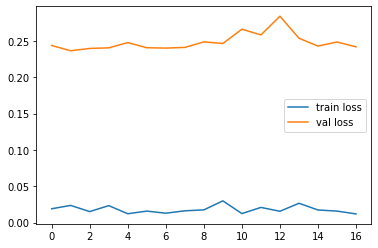

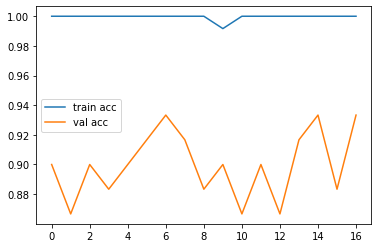

<Figure size 432x288 with 0 Axes>

In [76]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [77]:
model.save('model_vgg19_b16_ep_10_acc_93.33.h5')

In [78]:
y_pred = model.predict(test_set)

In [79]:
y_pred

array([[1.6283944e-02, 9.8371601e-01],
       [9.9945647e-01, 5.4349680e-04],
       [9.9772197e-01, 2.2780513e-03],
       [9.1397232e-01, 8.6027652e-02],
       [6.8447649e-02, 9.3155229e-01],
       [2.5003546e-01, 7.4996454e-01],
       [6.3142492e-05, 9.9993682e-01],
       [9.9831212e-01, 1.6878397e-03],
       [9.9608862e-01, 3.9114058e-03],
       [6.7667461e-06, 9.9999321e-01],
       [2.5518659e-01, 7.4481338e-01],
       [7.9076564e-01, 2.0923440e-01],
       [9.3785989e-01, 6.2140159e-02],
       [2.2201452e-01, 7.7798545e-01],
       [1.1752404e-03, 9.9882478e-01],
       [1.5873611e-03, 9.9841261e-01],
       [9.8716658e-01, 1.2833460e-02],
       [1.3283816e-03, 9.9867165e-01],
       [5.2726340e-05, 9.9994731e-01],
       [9.9601030e-02, 9.0039891e-01],
       [1.7042059e-01, 8.2957947e-01],
       [9.9994814e-01, 5.1896710e-05],
       [3.7060011e-02, 9.6293992e-01],
       [6.2627250e-01, 3.7372747e-01],
       [9.9882311e-01, 1.1768624e-03],
       [5.6801838e-01, 4.

In [1]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input
model=load_model('model_vgg19_b16_ep_10_acc_93.33.h5')

#### 1 means there is hemorrhage; 0 means normal slice.

In [78]:
#img=image.load_img('output/test/0/193.png',target_size=(224,224))
#img=image.load_img('output/test/1/042.png',target_size=(224,224))
#img=image.load_img('output/test/1/068.png',target_size=(224,224))
#img=image.load_img('output/test/1/073.png',target_size=(224,224))
img=image.load_img('output/test/1/093.png',target_size=(224,224))

In [79]:
x=image.img_to_array(img)

In [80]:
import numpy as np
x=np.expand_dims(x,axis=0)
img_data=preprocess_input(x)
img_data.shape

(1, 224, 224, 3)

In [81]:
model.predict(img_data)

array([[2.408254e-16, 1.000000e+00]], dtype=float32)

In [82]:
a=np.argmax(model.predict(img_data), axis=1)
if(a==0):
    print("Normal")
else:
    print("Brain Hemorrhage")

Brain Hemorrhage


## On the given dataset model looks to have a great recall but a low Precision i.e. It mostly detects Normal as defected but rarely detects Defective as normal